In [1]:
# Load python modules
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Resizing, Rescaling
import seaborn as sns
#import tensorflow_datasets as tfds
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
import cv2
import os

In [2]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (64, 64)

In [3]:
print('Number of classes:', nb_classes)

Number of classes: 4


In [4]:
class_names_label

{'Glass': 0, 'Metal': 1, 'Paper': 2, 'Textile': 3}

In [5]:
resize_layer_32 = tf.keras.Sequential([
    Resizing(32, 32),
])

In [6]:
# Path to Dataset1e

# Dataset with 4 classes - 270 images for training and 50 images for testing per class
train_ds_1 = 'C:/Mani/Dataset/dataset1/train_ds'
test_ds_1 = 'C:/Mani/Dataset/dataset1/test_ds'

# Dataset with 4 classes - 450 images for training with data augmentation images and 50 images for testing
train_ds_2 = 'C:/Mani/Dataset/dataset2/train_ds'
test_ds_2 = 'C:/Mani/Dataset/dataset2/test_ds'

# Dataset with 6 classes - 450 images for training with data augmentation images and 50 images for testing
train_ds_3 = 'C:/Mani/Dataset/dataset3/train_ds'
test_ds_3 = 'C:/Mani/Dataset/dataset3/test_ds'



In [7]:
def load_data(train_path, test_path):
    """
        Load the data from local folder
        
    """
    datasets = [train_path, test_path]  
    
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        #Empty Image and Labels list
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [8]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data(train_ds_2, test_ds_2)

Loading C:/Mani/Dataset/dataset2/train_ds


100%|███████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 231.97it/s]


Loading C:/Mani/Dataset/dataset2/test_ds


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 195.73it/s]


In [9]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1800, 64, 64, 3), (200, 64, 64, 3))

In [10]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)

In [11]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1800


In [12]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

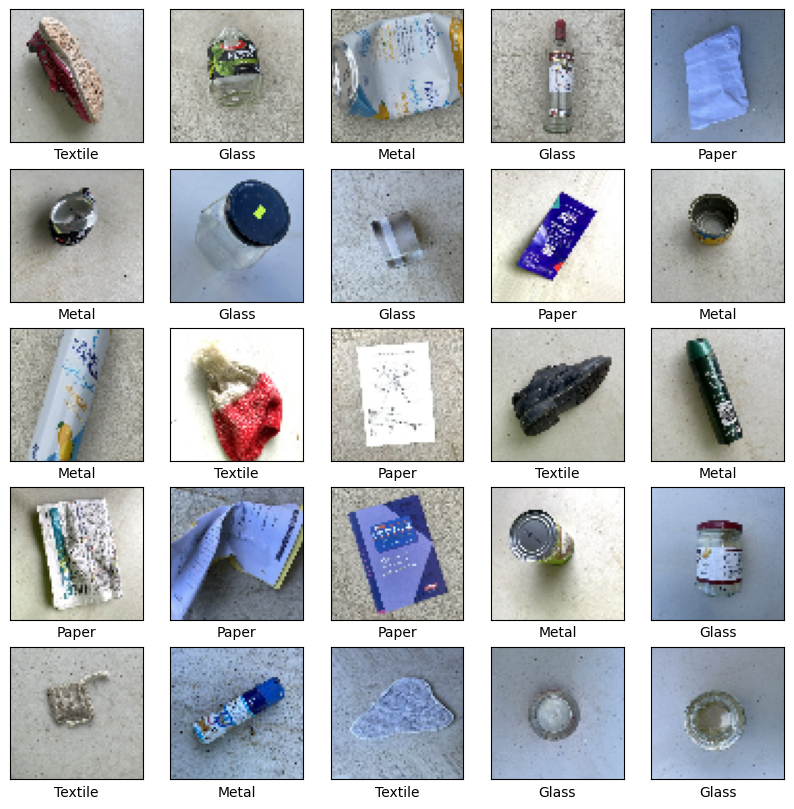

In [13]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [14]:
#Sequential Model 1
# Experience 3 with Batch Normalisation
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    #resize_layer_32,
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.2), activation='hard_swish'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.2), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.2), activation = 'relu'),   
    tf.keras.layers.Dense(64, activation = 'hard_swish'),
    #tf.keras.layers.Dense(32, activation = 'hard_swish'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,125,572 (8.11 MB)

 Trainable params: 2,125,380 (8.11 MB)

 Non-trainable params: 192 (768.00 B)

In [15]:
#Sequential Model 2 
# With Batch Normalisation

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    #Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    
    #Block2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    
    #Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.06), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    
    #Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.06), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),
       
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'hard_swish'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 234,052 (914.27 KB)

 Trainable params: 233,476 (912.02 KB)

 Non-trainable params: 576 (2.25 KB)

In [16]:
#Sequential Model 3 
# Model 3 with batch normalisation

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.06), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (5,5), padding='same', kernel_regularizer=regularizers.l2(0.06), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.07), activation ='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.4),
    
    # Block 4
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.07), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),
    
    #Block 5
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.07), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation ='relu6'),
    #tf.keras.layers.Dense(32, activation = 'relu6'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 64)            │              

 Total params: 357,412 (1.36 MB)

 Trainable params: 356,580 (1.36 MB)

 Non-trainable params: 832 (3.25 KB)

In [17]:
# Add callbacks to save the model weight with best accuracy during training

#import ModelCheckpoint package
#from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [18]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(0.0013),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(0.00098),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

In [19]:
#Learning rate scheduler for Model 1 and 2

def scheduler1(epoch, lr):
    if epoch <= 30:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback1 = LearningRateScheduler(scheduler1, verbose=1)

In [20]:
#Learning rate scheduler for Model 3

def scheduler2(epoch, lr):
    if epoch <= 65:
        return lr
    else:
        return lr * 0.96
        
    
lr_callback2 = LearningRateScheduler(scheduler2, verbose=1)

In [21]:
# Set number of epochs
epochs = 150
epochs1 = 200
batch_size = 64

In [22]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history1 = model_1.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs1,
                      validation_split = 0.1, verbose=1,
                      callbacks=[lr_callback2, model_checkpoint_callback1])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_1_training_time', end_time - start_time)


Time model start: 2024-12-06 23:02:20.281762

Epoch 1: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.3173 - loss: 49.7317
Epoch 1: val_accuracy improved from -inf to 0.27222, saving model to C:/Mani/ModelCheckpoint/model1.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/step - accuracy: 0.3183 - loss: 49.2691 - val_accuracy: 0.2722 - val_loss: 16.4016 - learning_rate: 0.0013

Epoch 2: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.3791 - loss: 12.4234
Epoch 2: val_accuracy improved from 0.27222 to 0.30000, saving model to C:/Mani/ModelCheckpoint/model1.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.3800 - loss: 12.3203 - val_accuracy: 0.3000 - val_loss: 5.5365 - learning_rate: 0.0013

Epoch 3: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━


Epoch 20: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 20/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6499 - loss: 2.1301
Epoch 20: val_accuracy did not improve from 0.45556
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.6495 - loss: 2.1295 - val_accuracy: 0.2833 - val_loss: 2.4443 - learning_rate: 0.0013

Epoch 21: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 21/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6110 - loss: 2.1107
Epoch 21: val_accuracy did not improve from 0.45556
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.6111 - loss: 2.1130 - val_accuracy: 0.2611 - val_loss: 3.2696 - learning_rate: 0.0013

Epoch 22: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 22/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6000 - loss: 2.3053
Epoch 22: val_accuracy improved from 0.45556 to 0.49444, saving model to C:/Mani/ModelCheckpoint/model1.ker

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step - accuracy: 0.6619 - loss: 2.0263 - val_accuracy: 0.3833 - val_loss: 2.4547 - learning_rate: 0.0013

Epoch 39: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 39/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6957 - loss: 1.9694
Epoch 39: val_accuracy did not improve from 0.58889
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.6954 - loss: 1.9701 - val_accuracy: 0.5333 - val_loss: 2.2485 - learning_rate: 0.0013

Epoch 40: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 40/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6762 - loss: 2.0973
Epoch 40: val_accuracy did not improve from 0.58889
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 295ms/step - accuracy: 0.6764 - loss: 2.0978 - val_accuracy: 0.2611 - val_loss: 4.5346 - learning_rate: 0.0013

Epoch 41: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 41/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7289 - loss: 1.8691
Epoch 57: val_accuracy did not improve from 0.67222
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.7286 - loss: 1.8688 - val_accuracy: 0.5889 - val_loss: 2.0678 - learning_rate: 0.0013

Epoch 58: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 58/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7578 - loss: 1.7625
Epoch 58: val_accuracy did not improve from 0.67222
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.7572 - loss: 1.7641 - val_accuracy: 0.4556 - val_loss: 2.2171 - learning_rate: 0.0013

Epoch 59: LearningRateScheduler setting learning rate to 0.0013000000035390258.
Epoch 59/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6991 - loss: 1.9096
Epoch 59: val_accuracy did not improve from 0.67222
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step - accuracy: 0.6991 - loss: 1.9101 - val_accuracy: 0.6167 - val_loss: 2.0138 - learning_rate: 0.0013

Epoch 6


Epoch 76: LearningRateScheduler setting learning rate to 0.0008642822876572608.
Epoch 76/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7908 - loss: 1.4526
Epoch 76: val_accuracy did not improve from 0.73889
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.7910 - loss: 1.4530 - val_accuracy: 0.5278 - val_loss: 2.0637 - learning_rate: 8.6428e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.000829711016267538.
Epoch 77/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8221 - loss: 1.3367
Epoch 77: val_accuracy did not improve from 0.73889
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.8218 - loss: 1.3370 - val_accuracy: 0.7000 - val_loss: 1.6977 - learning_rate: 8.2971e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.0007965225912630558.
Epoch 78/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8110 - loss: 1.3009
Epoch 78: val_accuracy did not improve from 0.73889
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accur


Epoch 95: LearningRateScheduler setting learning rate to 0.00039793213829398156.
Epoch 95/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9050 - loss: 0.7744
Epoch 95: val_accuracy did not improve from 0.80556
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.9048 - loss: 0.7742 - val_accuracy: 0.7333 - val_loss: 1.1565 - learning_rate: 3.9793e-04

Epoch 96: LearningRateScheduler setting learning rate to 0.00038201484829187394.
Epoch 96/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9032 - loss: 0.7450
Epoch 96: val_accuracy did not improve from 0.80556
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.9030 - loss: 0.7456 - val_accuracy: 0.7944 - val_loss: 1.0556 - learning_rate: 3.8201e-04

Epoch 97: LearningRateScheduler setting learning rate to 0.0003667342476546764.
Epoch 97/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9162 - loss: 0.7256
Epoch 97: val_accuracy did not improve from 0.80556
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - ac

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9380 - loss: 0.5365
Epoch 113: val_accuracy did not improve from 0.87778
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.9378 - loss: 0.5367 - val_accuracy: 0.8500 - val_loss: 0.7341 - learning_rate: 1.9085e-04

Epoch 114: LearningRateScheduler setting learning rate to 0.0001832155929878354.
Epoch 114/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9348 - loss: 0.5155
Epoch 114: val_accuracy did not improve from 0.87778
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.9350 - loss: 0.5154 - val_accuracy: 0.7000 - val_loss: 1.0604 - learning_rate: 1.8322e-04

Epoch 115: LearningRateScheduler setting learning rate to 0.00017588697373867033.
Epoch 115/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9403 - loss: 0.5010
Epoch 115: val_accuracy did not improve from 0.87778
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.9403 - loss: 0.5012 - val_accuracy: 0.7611 - val_loss: 0.9455 - learning_rate:


Epoch 132: LearningRateScheduler setting learning rate to 8.787082973867654e-05.
Epoch 132/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9617 - loss: 0.3838
Epoch 132: val_accuracy improved from 0.88333 to 0.88889, saving model to C:/Mani/ModelCheckpoint/model1.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step - accuracy: 0.9616 - loss: 0.3843 - val_accuracy: 0.8889 - val_loss: 0.6169 - learning_rate: 8.7871e-05

Epoch 133: LearningRateScheduler setting learning rate to 8.43559973873198e-05.
Epoch 133/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9614 - loss: 0.3852
Epoch 133: val_accuracy did not improve from 0.88889
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.9615 - loss: 0.3851 - val_accuracy: 0.8611 - val_loss: 0.6396 - learning_rate: 8.4356e-05

Epoch 134: LearningRateScheduler setting learning rate to 8.098175749182701e-05.
Epoch 134/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9675 - loss: 0.3860
Epoch 134: val_accuracy did not im

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9672 - loss: 0.3420
Epoch 150: val_accuracy did not improve from 0.90000
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step - accuracy: 0.9672 - loss: 0.3419 - val_accuracy: 0.8833 - val_loss: 0.5652 - learning_rate: 4.2143e-05

Epoch 151: LearningRateScheduler setting learning rate to 4.045741399750113e-05.
Epoch 151/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9736 - loss: 0.3268
Epoch 151: val_accuracy did not improve from 0.90000
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - accuracy: 0.9736 - loss: 0.3267 - val_accuracy: 0.8944 - val_loss: 0.5565 - learning_rate: 4.0457e-05

Epoch 152: LearningRateScheduler setting learning rate to 3.883911645971238e-05.
Epoch 152/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9807 - loss: 0.3119
Epoch 152: val_accuracy did not improve from 0.90000
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.9806 - loss: 0.3121 - val_accuracy: 0.8667 - val_loss: 0.5644 - learning_rate: 


Epoch 169: LearningRateScheduler setting learning rate to 1.9403510377742348e-05.
Epoch 169/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9826 - loss: 0.3053
Epoch 169: val_accuracy did not improve from 0.91111
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 287ms/step - accuracy: 0.9825 - loss: 0.3051 - val_accuracy: 0.9000 - val_loss: 0.5141 - learning_rate: 1.9404e-05

Epoch 170: LearningRateScheduler setting learning rate to 1.8627370591275393e-05.
Epoch 170/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9797 - loss: 0.2920
Epoch 170: val_accuracy did not improve from 0.91111
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.9798 - loss: 0.2919 - val_accuracy: 0.8944 - val_loss: 0.5235 - learning_rate: 1.8627e-05

Epoch 171: LearningRateScheduler setting learning rate to 1.7882275278680024e-05.
Epoch 171/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9832 - loss: 0.2843
Epoch 171: val_accuracy did not improve from 0.91111
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms


Epoch 188: LearningRateScheduler setting learning rate to 8.933749340940266e-06.
Epoch 188/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9784 - loss: 0.2891
Epoch 188: val_accuracy did not improve from 0.91111
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.9785 - loss: 0.2890 - val_accuracy: 0.8944 - val_loss: 0.5117 - learning_rate: 8.9337e-06

Epoch 189: LearningRateScheduler setting learning rate to 8.57639912283048e-06.
Epoch 189/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9849 - loss: 0.2727
Epoch 189: val_accuracy did not improve from 0.91111
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.9848 - loss: 0.2731 - val_accuracy: 0.8889 - val_loss: 0.5155 - learning_rate: 8.5764e-06

Epoch 190: LearningRateScheduler setting learning rate to 8.233343542087822e-06.
Epoch 190/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9850 - loss: 0.2843
Epoch 190: val_accuracy did not improve from 0.91111
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/ste

In [23]:

# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs1, 
                       validation_split = 0.1, verbose=1,
                       callbacks=[lr_callback2, model_checkpoint_callback2])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_2_training_time', end_time - start_time)


Time model start: 2024-12-06 23:27:51.021904

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.2797 - loss: 14.4083
Epoch 1: val_accuracy improved from -inf to 0.26111, saving model to C:/Mani/ModelCheckpoint/model2.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - accuracy: 0.2813 - loss: 14.3878 - val_accuracy: 0.2611 - val_loss: 12.3141 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.3903 - loss: 12.1103
Epoch 2: val_accuracy did not improve from 0.26111
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.3913 - loss: 12.0907 - val_accuracy: 0.2611 - val_loss: 10.4871 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.4490 - loss: 9.8425
Epoch 3:


Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7302 - loss: 1.2004
Epoch 20: val_accuracy did not improve from 0.26111
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.7304 - loss: 1.2002 - val_accuracy: 0.2611 - val_loss: 3.9831 - learning_rate: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 21/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7338 - loss: 1.1616
Epoch 21: val_accuracy improved from 0.26111 to 0.50000, saving model to C:/Mani/ModelCheckpoint/model2.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.7333 - loss: 1.1634 - val_accuracy: 0.5000 - val_loss: 1.6883 - learning_rate: 0.0010

Epoch 22: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 22/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7654 - loss: 1.1302
Epoch 22: val_accuracy did not improve from 0.500

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8184 - loss: 1.0011
Epoch 38: val_accuracy did not improve from 0.68889
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - accuracy: 0.8188 - loss: 1.0003 - val_accuracy: 0.5833 - val_loss: 1.5003 - learning_rate: 0.0010

Epoch 39: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 39/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.7960 - loss: 1.0121
Epoch 39: val_accuracy did not improve from 0.68889
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.7960 - loss: 1.0127 - val_accuracy: 0.6056 - val_loss: 1.4578 - learning_rate: 0.0010

Epoch 40: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 40/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.8088 - loss: 0.9909
Epoch 40: val_accuracy did not improve from 0.68889
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - accuracy: 0.8088 - loss: 0.9911 - val_accuracy: 0.5833 - val_loss: 1.4633 - learning_rate: 0.0010

Epoch 4

Epoch 57/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8332 - loss: 1.0264
Epoch 57: val_accuracy did not improve from 0.76667
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.8331 - loss: 1.0261 - val_accuracy: 0.4500 - val_loss: 1.9003 - learning_rate: 0.0010

Epoch 58: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 58/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8334 - loss: 1.0168
Epoch 58: val_accuracy did not improve from 0.76667
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.8326 - loss: 1.0179 - val_accuracy: 0.6111 - val_loss: 1.7138 - learning_rate: 0.0010

Epoch 59: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 59/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8287 - loss: 1.0177
Epoch 59: val_accuracy did not improve from 0.76667
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.8289 - loss: 1.0166 - val_accuracy: 0.4778 - val_loss: 1.7915 - learning_rate: 0.

Epoch 76/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8711 - loss: 0.7868
Epoch 76: val_accuracy did not improve from 0.80000
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.8709 - loss: 0.7873 - val_accuracy: 0.4889 - val_loss: 2.1293 - learning_rate: 6.6483e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.0006382392905652523.
Epoch 77/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8689 - loss: 0.8083
Epoch 77: val_accuracy did not improve from 0.80000
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.8684 - loss: 0.8090 - val_accuracy: 0.7667 - val_loss: 1.0285 - learning_rate: 6.3824e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.0006127097457647323.
Epoch 78/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8871 - loss: 0.7824
Epoch 78: val_accuracy did not improve from 0.80000
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.8866 - loss: 0.7826 - val_accuracy: 0.6500 - val_loss: 1.4207 - learning_


Epoch 95: LearningRateScheduler setting learning rate to 0.0003061017114669084.
Epoch 95/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9364 - loss: 0.5500
Epoch 95: val_accuracy did not improve from 0.88889
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.9359 - loss: 0.5506 - val_accuracy: 0.7556 - val_loss: 0.9010 - learning_rate: 3.0610e-04

Epoch 96: LearningRateScheduler setting learning rate to 0.00029385765083134174.
Epoch 96/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9267 - loss: 0.5324
Epoch 96: val_accuracy did not improve from 0.88889
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.9263 - loss: 0.5334 - val_accuracy: 0.7722 - val_loss: 0.8914 - learning_rate: 2.9386e-04

Epoch 97: LearningRateScheduler setting learning rate to 0.00028210334479808805.
Epoch 97/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9305 - loss: 0.5364
Epoch 97: val_accuracy did not improve from 0.88889
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - ac


Epoch 114: LearningRateScheduler setting learning rate to 0.00014093510806560515.
Epoch 114/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9688 - loss: 0.3685
Epoch 114: val_accuracy did not improve from 0.88889
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.9687 - loss: 0.3683 - val_accuracy: 0.8833 - val_loss: 0.5476 - learning_rate: 1.4094e-04

Epoch 115: LearningRateScheduler setting learning rate to 0.00013529770541936158.
Epoch 115/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9742 - loss: 0.3467
Epoch 115: val_accuracy improved from 0.88889 to 0.91111, saving model to C:/Mani/ModelCheckpoint/model2.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.9740 - loss: 0.3469 - val_accuracy: 0.9111 - val_loss: 0.4883 - learning_rate: 1.3530e-04

Epoch 116: LearningRateScheduler setting learning rate to 0.00012988580390810967.
Epoch 116/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9532 - loss: 0.3780
Epoch 116: val_accuracy did no

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9744 - loss: 0.2888
Epoch 132: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.9741 - loss: 0.2892 - val_accuracy: 0.8944 - val_loss: 0.4751 - learning_rate: 6.7593e-05

Epoch 133: LearningRateScheduler setting learning rate to 6.488922284916043e-05.
Epoch 133/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9735 - loss: 0.2877
Epoch 133: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.9736 - loss: 0.2875 - val_accuracy: 0.8944 - val_loss: 0.4777 - learning_rate: 6.4889e-05

Epoch 134: LearningRateScheduler setting learning rate to 6.229365477338432e-05.
Epoch 134/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9722 - loss: 0.2844
Epoch 134: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.9722 - loss: 0.2845 - val_accuracy: 0.8611 - val_loss: 0.6116 - learning_rate: 


Epoch 151: LearningRateScheduler setting learning rate to 3.112108795903623e-05.
Epoch 151/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9805 - loss: 0.2381
Epoch 151: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.9805 - loss: 0.2380 - val_accuracy: 0.8611 - val_loss: 0.5453 - learning_rate: 3.1121e-05

Epoch 152: LearningRateScheduler setting learning rate to 2.9876246117055416e-05.
Epoch 152/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9813 - loss: 0.2384
Epoch 152: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.9814 - loss: 0.2383 - val_accuracy: 0.9111 - val_loss: 0.4368 - learning_rate: 2.9876e-05

Epoch 153: LearningRateScheduler setting learning rate to 2.8681196272373197e-05.
Epoch 153/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9856 - loss: 0.2338
Epoch 153: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/


Epoch 170: LearningRateScheduler setting learning rate to 1.4328748220577835e-05.
Epoch 170/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9840 - loss: 0.2267
Epoch 170: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.9840 - loss: 0.2267 - val_accuracy: 0.8722 - val_loss: 0.4384 - learning_rate: 1.4329e-05

Epoch 171: LearningRateScheduler setting learning rate to 1.3755598047282547e-05.
Epoch 171/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9837 - loss: 0.2227
Epoch 171: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.9838 - loss: 0.2227 - val_accuracy: 0.8889 - val_loss: 0.4654 - learning_rate: 1.3756e-05

Epoch 172: LearningRateScheduler setting learning rate to 1.3205374125391245e-05.
Epoch 172/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9851 - loss: 0.2214
Epoch 172: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms


Epoch 189: LearningRateScheduler setting learning rate to 6.5972305310424415e-06.
Epoch 189/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9800 - loss: 0.2196
Epoch 189: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.9801 - loss: 0.2194 - val_accuracy: 0.9000 - val_loss: 0.4244 - learning_rate: 6.5972e-06

Epoch 190: LearningRateScheduler setting learning rate to 6.333341152640059e-06.
Epoch 190/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9821 - loss: 0.2182
Epoch 190: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.9821 - loss: 0.2180 - val_accuracy: 0.9111 - val_loss: 0.4245 - learning_rate: 6.3333e-06

Epoch 191: LearningRateScheduler setting learning rate to 6.080007296986878e-06.
Epoch 191/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9884 - loss: 0.2219
Epoch 191: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/s

In [24]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs1, 
                       validation_split = 0.1, verbose=1,
                       callbacks=[lr_callback2, model_checkpoint_callback3])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_3_training_time', end_time - start_time )

Time model start: 2024-12-06 23:52:22.582598

Epoch 1: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.2875 - loss: 25.9590
Epoch 1: val_accuracy improved from -inf to 0.26111, saving model to C:/Mani/ModelCheckpoint/model3.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 353ms/step - accuracy: 0.2878 - loss: 25.9147 - val_accuracy: 0.2611 - val_loss: 22.6806 - learning_rate: 9.8000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.3138 - loss: 21.2870
Epoch 2: val_accuracy did not improve from 0.26111
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.3142 - loss: 21.2488 - val_accuracy: 0.2611 - val_loss: 18.8252 - learning_rate: 9.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.3604 - loss: 16.7447

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 360ms/step - accuracy: 0.4776 - loss: 1.9198 - val_accuracy: 0.3722 - val_loss: 3.6152 - learning_rate: 9.8000e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 20/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5228 - loss: 1.8109
Epoch 20: val_accuracy improved from 0.37222 to 0.46111, saving model to C:/Mani/ModelCheckpoint/model3.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 355ms/step - accuracy: 0.5230 - loss: 1.8106 - val_accuracy: 0.4611 - val_loss: 1.9989 - learning_rate: 9.8000e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 21/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.5008 - loss: 1.8009
Epoch 21: val_accuracy did not improve from 0.46111
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 350ms/step - accuracy: 0.5011 - loss: 1.8014 - val_accuracy: 0.2944 - val_loss: 3.6951 - learning_rate: 9.8000e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00098


Epoch 38: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 38/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.6011 - loss: 1.7215
Epoch 38: val_accuracy did not improve from 0.58889
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - accuracy: 0.6022 - loss: 1.7195 - val_accuracy: 0.5056 - val_loss: 1.8593 - learning_rate: 9.8000e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 39/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.6492 - loss: 1.5923
Epoch 39: val_accuracy did not improve from 0.58889
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.6488 - loss: 1.5932 - val_accuracy: 0.4222 - val_loss: 2.5557 - learning_rate: 9.8000e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 40/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.6285 - loss: 1.6561
Epoch 40: val_accuracy did not improve from 0.58889
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accu


Epoch 57: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 57/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6686 - loss: 1.5414
Epoch 57: val_accuracy did not improve from 0.68889
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.6681 - loss: 1.5437 - val_accuracy: 0.4444 - val_loss: 2.1306 - learning_rate: 9.8000e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 58/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6401 - loss: 1.7143
Epoch 58: val_accuracy did not improve from 0.68889
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.6405 - loss: 1.7136 - val_accuracy: 0.2556 - val_loss: 4.0265 - learning_rate: 9.8000e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 59/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6672 - loss: 1.6207
Epoch 59: val_accuracy did not improve from 0.68889
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accu


Epoch 76: LearningRateScheduler setting learning rate to 0.0006515360623598099.
Epoch 76/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7375 - loss: 1.3858
Epoch 76: val_accuracy improved from 0.69444 to 0.70000, saving model to C:/Mani/ModelCheckpoint/model3.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - accuracy: 0.7368 - loss: 1.3868 - val_accuracy: 0.7000 - val_loss: 1.5473 - learning_rate: 6.5154e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.000625474601984024.
Epoch 77/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.7193 - loss: 1.3910
Epoch 77: val_accuracy did not improve from 0.70000
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 346ms/step - accuracy: 0.7195 - loss: 1.3904 - val_accuracy: 0.3833 - val_loss: 2.1698 - learning_rate: 6.2547e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.0006004556268453598.
Epoch 78/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.7148 - loss: 1.3561
Epoch 78: val_accuracy did not improve fro

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.8308 - loss: 1.0694
Epoch 94: val_accuracy did not improve from 0.78333
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 344ms/step - accuracy: 0.8307 - loss: 1.0694 - val_accuracy: 0.6833 - val_loss: 1.4851 - learning_rate: 3.1248e-04

Epoch 95: LearningRateScheduler setting learning rate to 0.0002999796811491251.
Epoch 95/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8239 - loss: 1.0443
Epoch 95: val_accuracy did not improve from 0.78333
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.8238 - loss: 1.0440 - val_accuracy: 0.7500 - val_loss: 1.2457 - learning_rate: 2.9998e-04

Epoch 96: LearningRateScheduler setting learning rate to 0.0002879804838448763.
Epoch 96/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.8284 - loss: 1.0161
Epoch 96: val_accuracy improved from 0.78333 to 0.80556, saving model to C:/Mani/ModelCheckpoint/model3.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step - accuracy: 0.8282 - loss: 1.0162 - val_ac

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9069 - loss: 0.7466
Epoch 112: val_accuracy improved from 0.87778 to 0.88333, saving model to C:/Mani/ModelCheckpoint/model3.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - accuracy: 0.9069 - loss: 0.7471 - val_accuracy: 0.8833 - val_loss: 0.8111 - learning_rate: 1.4987e-04

Epoch 113: LearningRateScheduler setting learning rate to 0.00014387127477675675.
Epoch 113/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9027 - loss: 0.7300
Epoch 113: val_accuracy did not improve from 0.88333
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.9027 - loss: 0.7306 - val_accuracy: 0.7944 - val_loss: 0.9622 - learning_rate: 1.4387e-04

Epoch 114: LearningRateScheduler setting learning rate to 0.0001381164276972413.
Epoch 114/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9171 - loss: 0.7206
Epoch 114: val_accuracy did not improve from 0.88333
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - accuracy: 0.9167 - loss: 0.7214

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.9623 - loss: 0.5211 - val_accuracy: 0.8778 - val_loss: 0.7814 - learning_rate: 7.1876e-05

Epoch 131: LearningRateScheduler setting learning rate to 6.90011610276997e-05.
Epoch 131/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9525 - loss: 0.5457
Epoch 131: val_accuracy did not improve from 0.90556
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.9527 - loss: 0.5455 - val_accuracy: 0.8778 - val_loss: 0.7550 - learning_rate: 6.9001e-05

Epoch 132: LearningRateScheduler setting learning rate to 6.624111207202076e-05.
Epoch 132/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9466 - loss: 0.5476
Epoch 132: val_accuracy did not improve from 0.90556
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.9467 - loss: 0.5475 - val_accuracy: 0.9000 - val_loss: 0.7527 - learning_rate: 6.6241e-05

Epoch 133: LearningRateScheduler setting learning rate to 6.359146675094963e-05.
Epoch 133/200
26/26 ━━━━━━━━━━━━━━━━

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9688 - loss: 0.4503
Epoch 149: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.9688 - loss: 0.4503 - val_accuracy: 0.9167 - val_loss: 0.6220 - learning_rate: 3.3093e-05

Epoch 150: LearningRateScheduler setting learning rate to 3.176945960149169e-05.
Epoch 150/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9647 - loss: 0.4376
Epoch 150: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.9647 - loss: 0.4376 - val_accuracy: 0.8944 - val_loss: 0.7587 - learning_rate: 3.1769e-05

Epoch 151: LearningRateScheduler setting learning rate to 3.049868275411427e-05.
Epoch 151/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9829 - loss: 0.3996
Epoch 151: val_accuracy did not improve from 0.92778
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 0.9826 - loss: 0.4002 - val_accuracy: 0.9000 - val_loss: 0.6838 - learning_rate: 


Epoch 168: LearningRateScheduler setting learning rate to 1.5236737090162933e-05.
Epoch 168/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9760 - loss: 0.3816
Epoch 168: val_accuracy did not improve from 0.94444
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.9759 - loss: 0.3817 - val_accuracy: 0.9222 - val_loss: 0.5742 - learning_rate: 1.5237e-05

Epoch 169: LearningRateScheduler setting learning rate to 1.462726795580238e-05.
Epoch 169/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9893 - loss: 0.3643
Epoch 169: val_accuracy did not improve from 0.94444
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.9891 - loss: 0.3643 - val_accuracy: 0.9222 - val_loss: 0.5648 - learning_rate: 1.4627e-05

Epoch 170: LearningRateScheduler setting learning rate to 1.4042177062947302e-05.
Epoch 170/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9722 - loss: 0.3786
Epoch 170: val_accuracy did not improve from 0.94444
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/


Epoch 187: LearningRateScheduler setting learning rate to 7.015286682872101e-06.
Epoch 187/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9778 - loss: 0.3541
Epoch 187: val_accuracy did not improve from 0.95000
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.9779 - loss: 0.3538 - val_accuracy: 0.9389 - val_loss: 0.4850 - learning_rate: 7.0153e-06

Epoch 188: LearningRateScheduler setting learning rate to 6.7346754076424985e-06.
Epoch 188/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9764 - loss: 0.3623
Epoch 188: val_accuracy did not improve from 0.95000
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.9765 - loss: 0.3621 - val_accuracy: 0.9389 - val_loss: 0.4895 - learning_rate: 6.7347e-06

Epoch 189: LearningRateScheduler setting learning rate to 6.465288461185992e-06.
Epoch 189/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9820 - loss: 0.3544
Epoch 189: val_accuracy did not improve from 0.95000
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/s

Text(0.5, 1.0, 'Model 1 Accuracy (Exp:5.2)')

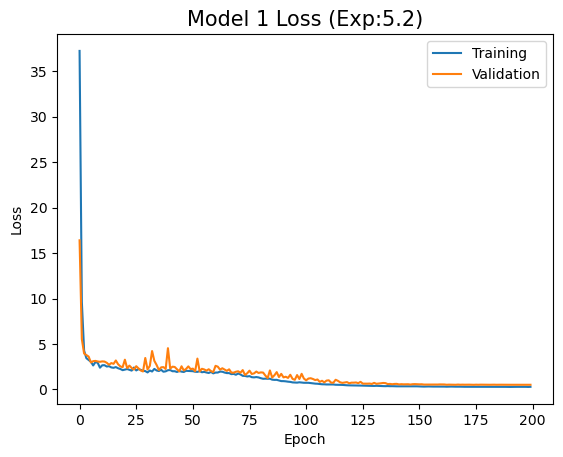

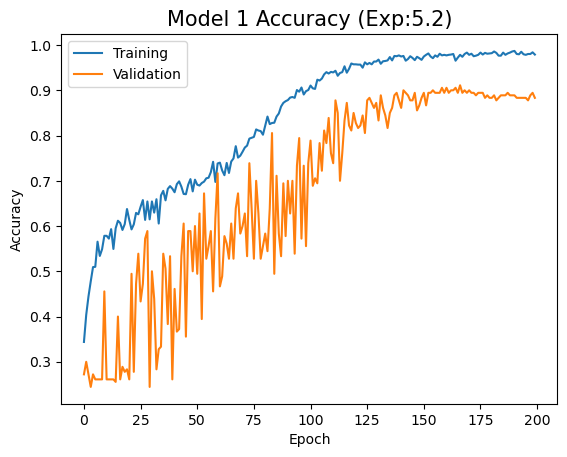

In [25]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 Loss (Exp:5.2)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy (Exp:5.2)', fontsize = 15)


Text(0.5, 1.0, 'Model 2 Accuracy (Exp:5.2)')

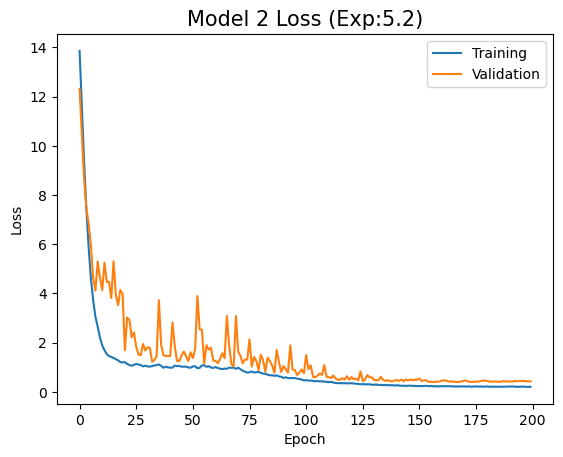

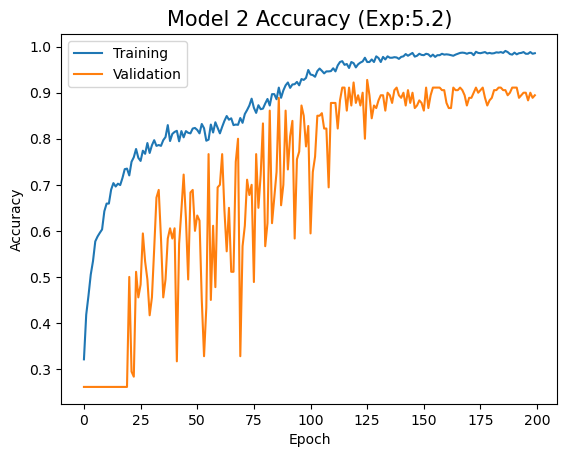

In [26]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss (Exp:5.2)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy (Exp:5.2)', fontsize = 15)

Text(0.5, 1.0, 'Model 3 Accuracy (Exp:5.2)')

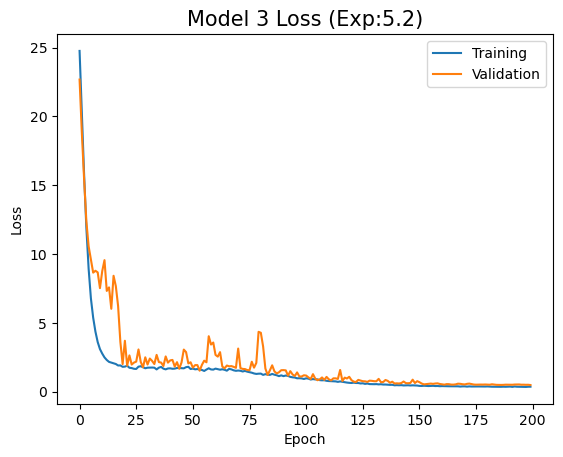

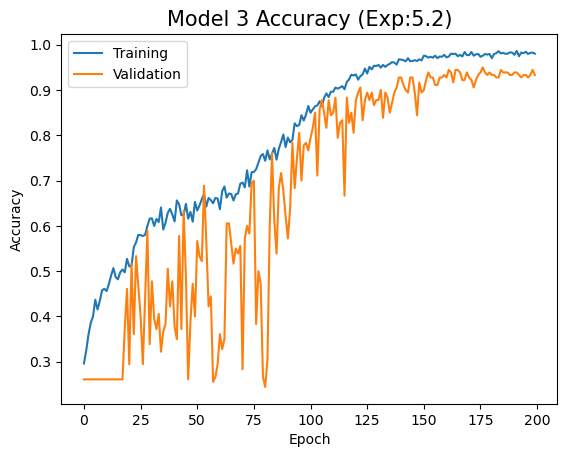

In [27]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss (Exp:5.2)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 3 Accuracy (Exp:5.2)', fontsize = 15)

In [28]:
# Evaluate the test result for model 1, 2, 3
model_1.load_weights(checkpoint_filepath1)
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

model_2.load_weights(checkpoint_filepath2)
Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

model_3.load_weights(checkpoint_filepath3)
Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9246 - loss: 0.4166
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9524 - loss: 0.3261
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9504 - loss: 0.4356


In [29]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


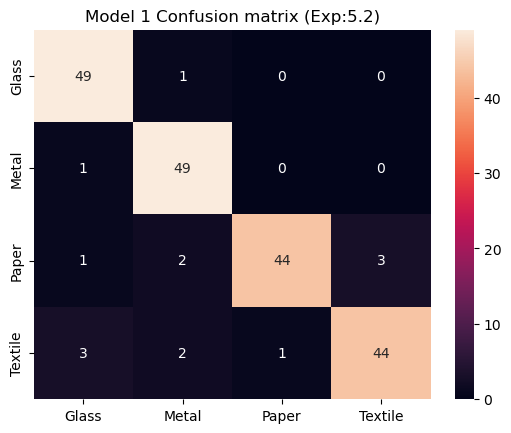

In [30]:
CM1 = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sns.heatmap(CM1, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 1 Confusion matrix (Exp:5.2)')
plt.show()

In [31]:
#Obtain the model's prediction for the test_images
predictions2 = model_2.predict(test_images)
pred_label2 = np.argmax(predictions2, axis = 1)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


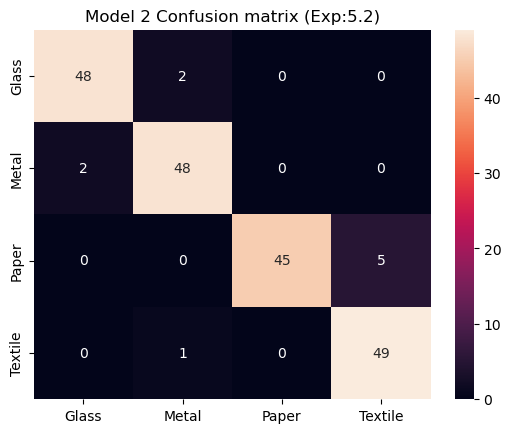

In [32]:
CM2 = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sns.heatmap(CM2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 2 Confusion matrix (Exp:5.2)')
plt.show()

In [33]:
#Obtain the model's prediction for the test_images
predictions3 = model_3.predict(test_images)
pred_label3 = np.argmax(predictions3, axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


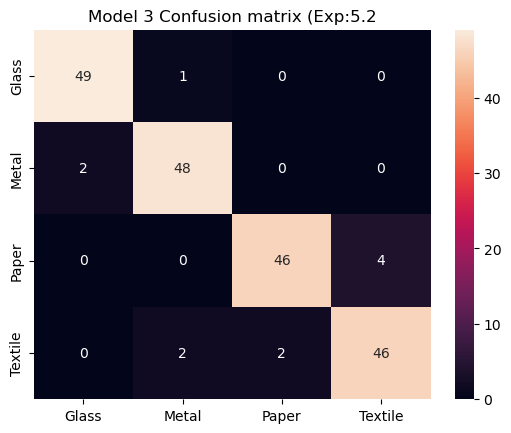

In [34]:
CM3 = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sns.heatmap(CM3, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 3 Confusion matrix (Exp:5.2')
plt.show()

25 random image with actual and predicted label for Model 1


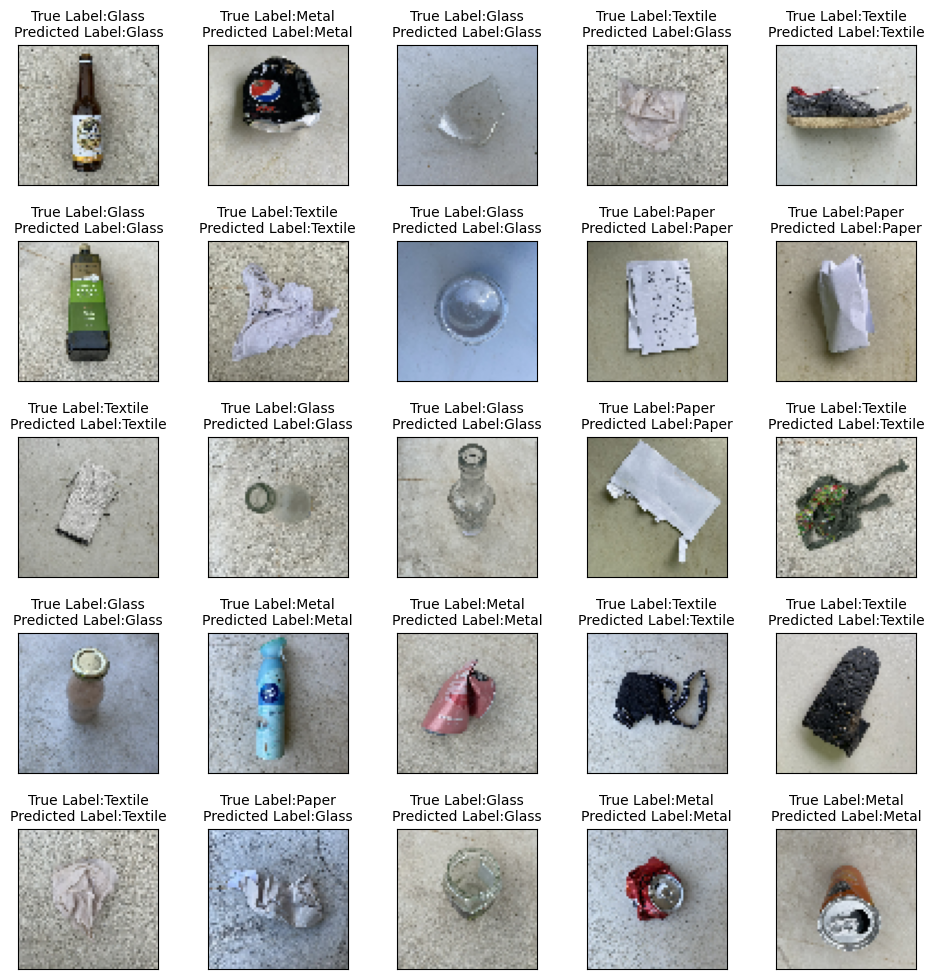

In [35]:
#Display actual and predicted labels for 25 images model 3
print('25 random image with actual and predicted label for Model 1')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + class_names[pred_label1[i]], fontsize = 10)
    
    
    #plt.show()

25 random image with actual and predicted label for Model 2


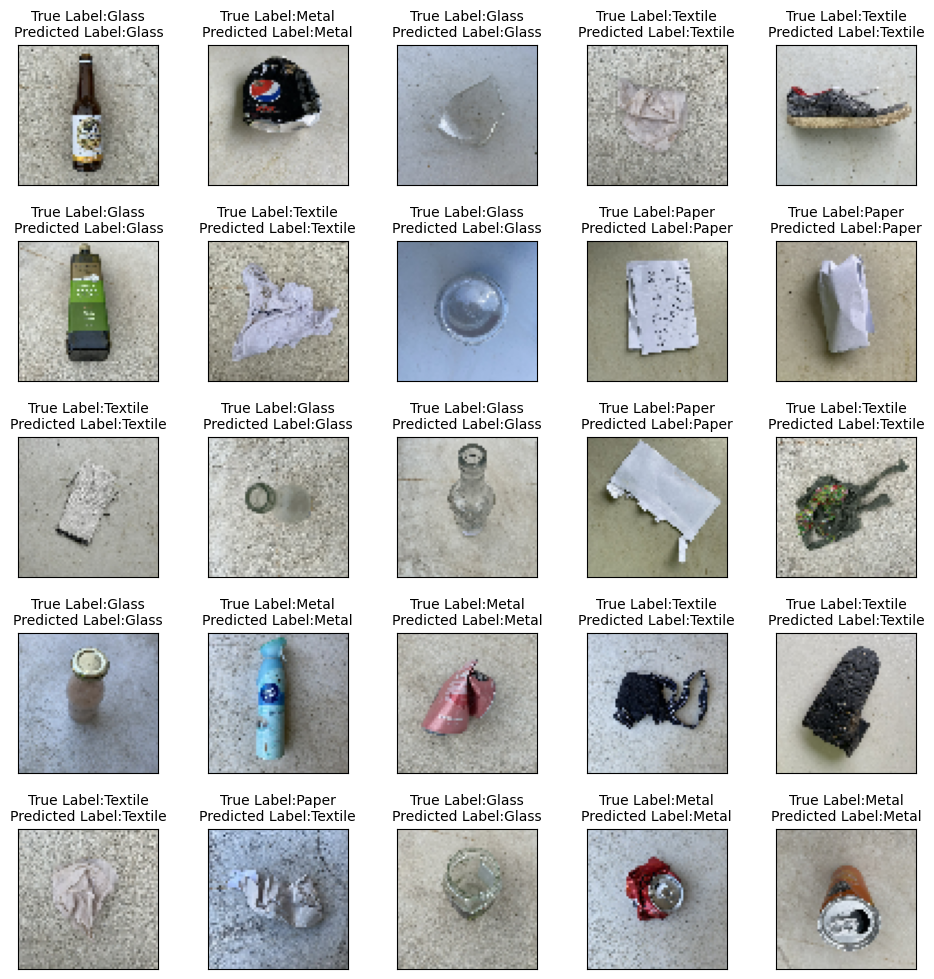

In [36]:
#Display actual and predicted labels for 25 images 
print('25 random image with actual and predicted label for Model 2')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + class_names[pred_label2[i]], fontsize = 10)
    

25 random image with actual and predicted label for Model 3


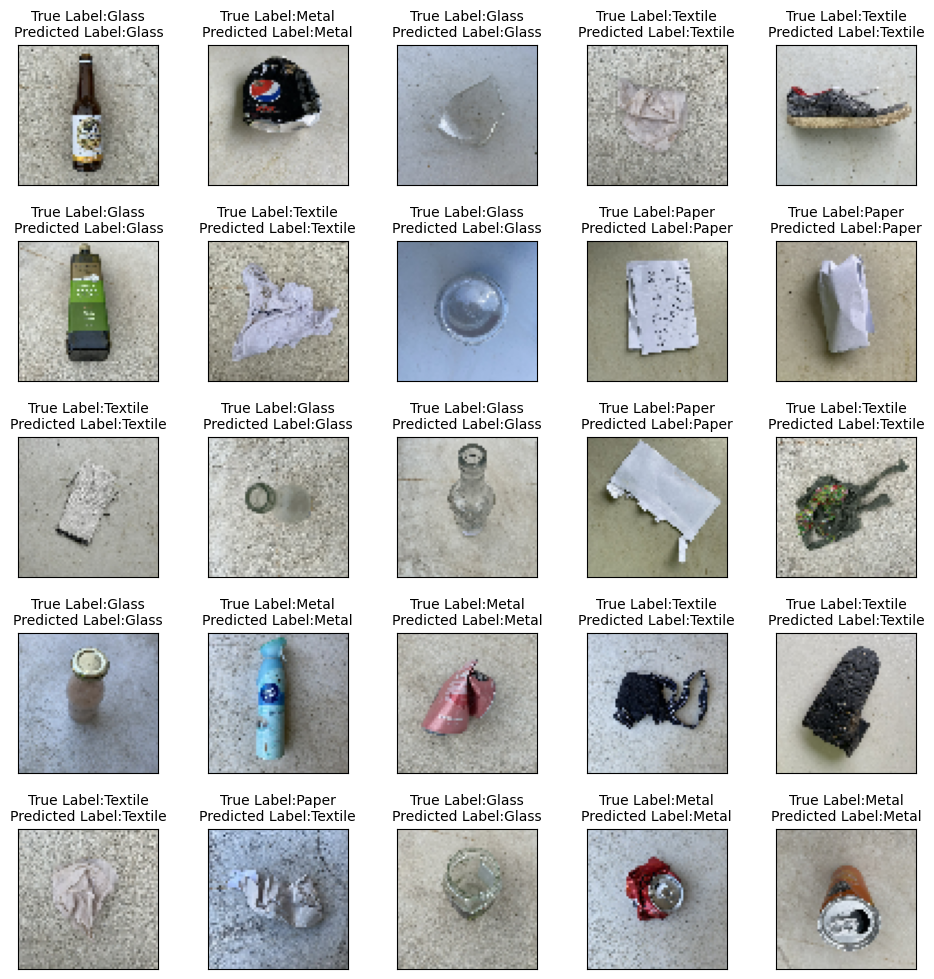

In [37]:
#Display actual and predicted labels for 25 images 
print('25 random image with actual and predicted label for Model 3')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + class_names[pred_label3[i]], fontsize = 10)
    

In [55]:
def display_mislabel_images(class_names, images, labels):
    """
        Display mislabel images from the images array with its corresponding labels
    """
  
    fig = plt.figure(figsize=(15,15))
    #fig.suptitle("mislabeled images", fontsize=16)
    for i in range(11):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]], fontsize = 15) 
    plt.show()

In [39]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print all the mislabeled images by the classifier
    """
    correct_label = (test_labels == pred_labels)
    mislabeled_indices = np.where(correct_label == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    #actual_label = test_labels[mislabeled_indices]

      
    display_mislabel_images(class_names,  mislabeled_images, mislabeled_labels)

Mislabel image for model 1


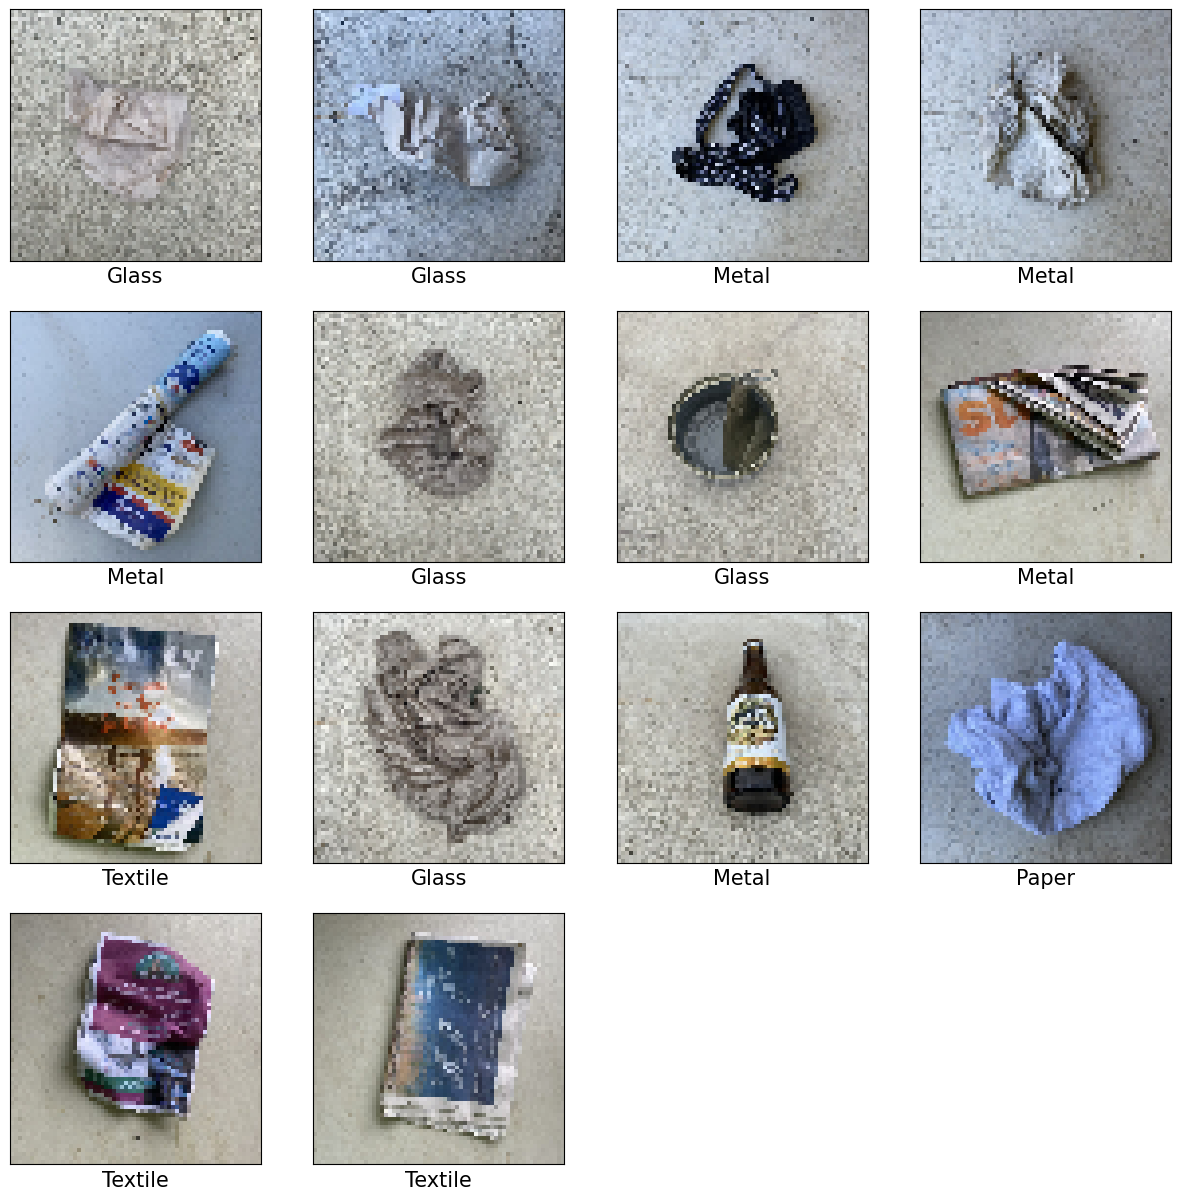

In [52]:
print('Mislabel image for model 1')
print_mislabeled_images(class_names, test_images, test_labels, pred_label1)

Mislabel image for model 2


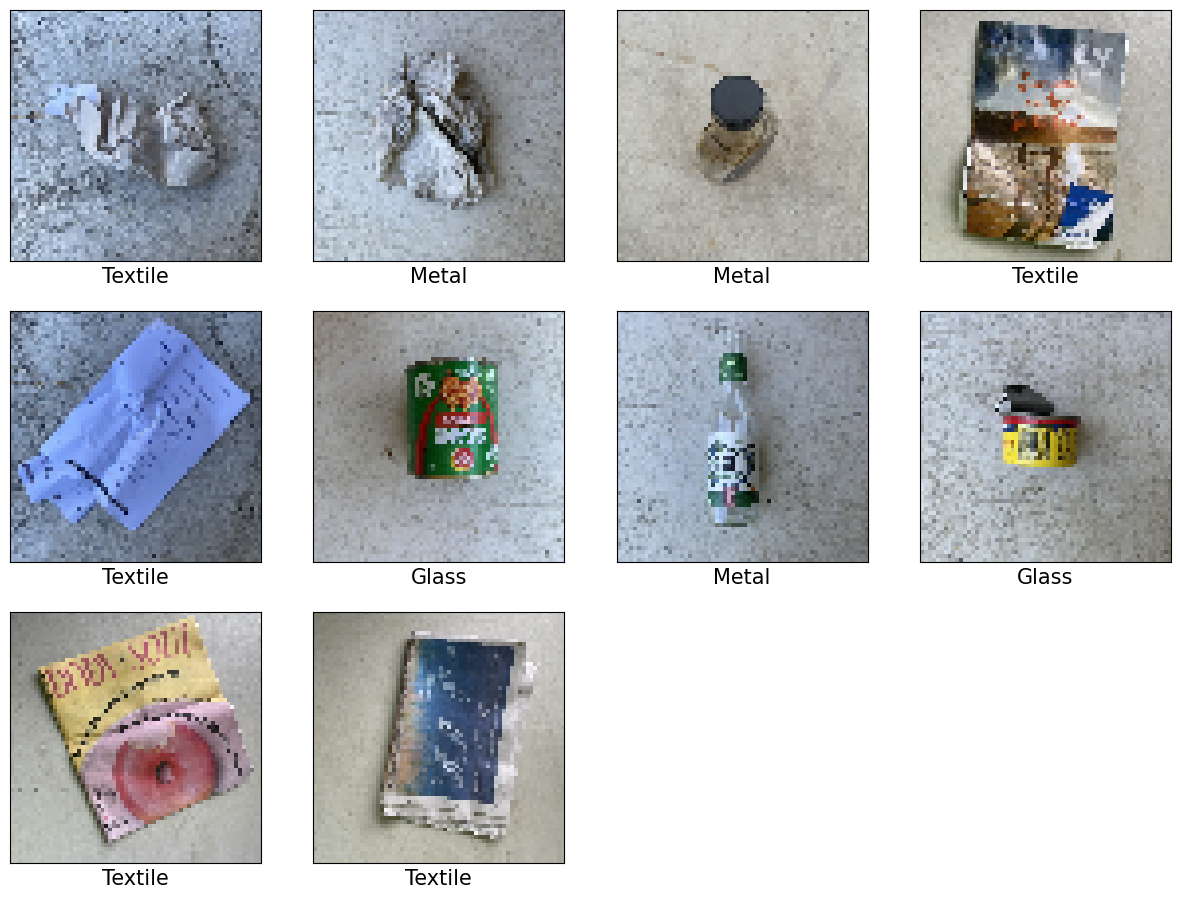

In [54]:
print('Mislabel image for model 2')
print_mislabeled_images(class_names, test_images, test_labels, pred_label2)

Mislabel image for model 3


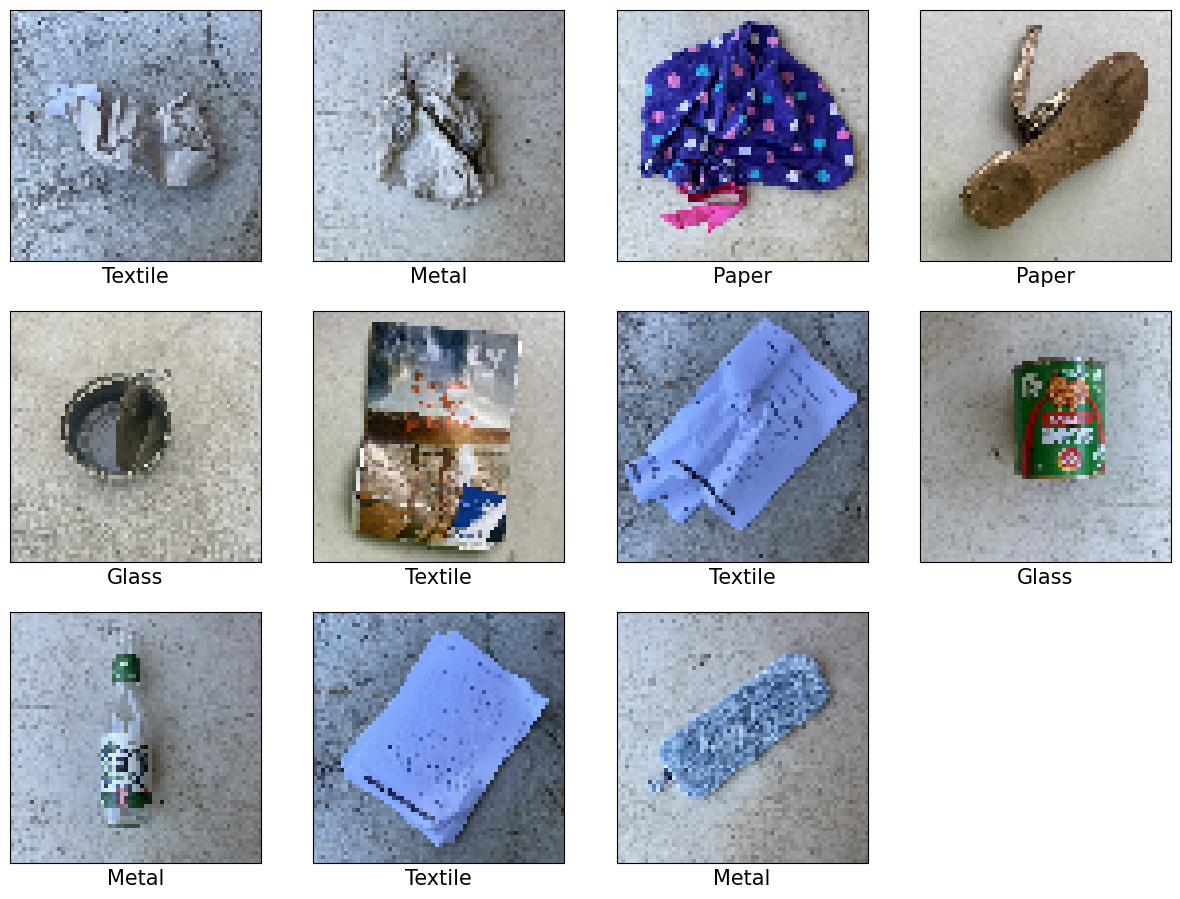

In [56]:
print('Mislabel image for model 3')
print_mislabeled_images(class_names, test_images, test_labels, pred_label3)

## Predict Single Image

Predict start: 2024-12-07 00:24:15.554035


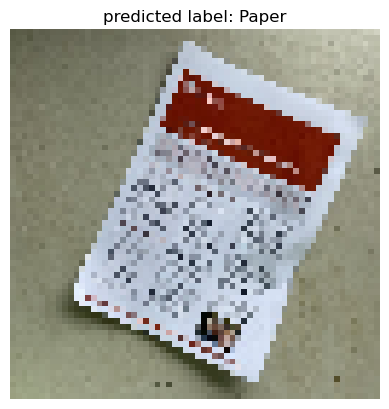

Predict end: 2024-12-07 00:24:15.666589
Prediction time: 0:00:00.112554


In [50]:
# Prediction time for model 1
start_time = datetime.now()
print('Predict start:', start_time)

IMAGE_SIZE = (64, 64)
#IMAGE_SIZE = (32, 32)
test_image1 = cv2.imread("C:/test_ds/Paper/Paper_2.jpg")
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)
test_image1 = cv2.resize(test_image1, IMAGE_SIZE) 
im1= tf.constant(test_image1, dtype = tf.float32)
im1= tf.expand_dims(im1,axis = 0)
plt.title('predicted label: ' + class_names[np.argmax(model_1(im1))])
plt.imshow(test_image1)
plt.grid(False)
plt.axis('off')
plt.show()

end_time = datetime.now()
print('Predict end:', end_time)
print('Prediction time:', end_time - start_time)

Predict start: 2024-12-07 00:22:25.251859


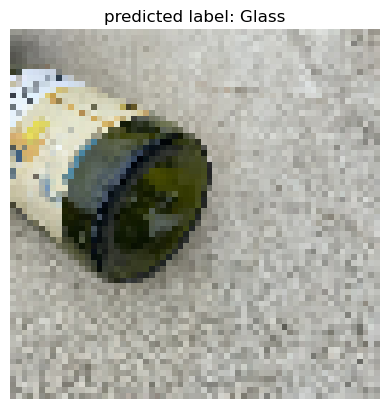

Predict end: 2024-12-07 00:22:25.368807
Prediction time: 0:00:00.116948


In [44]:
# Prediction time for model 2
start_time = datetime.now()
print('Predict start:', start_time)

IMAGE_SIZE = (64, 64)
test_image1 = cv2.imread("C:/test_ds/Glass/Glass_2.jpg")
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)
test_image1 = cv2.resize(test_image1, IMAGE_SIZE) 
im1= tf.constant(test_image1, dtype = tf.float32)
im1= tf.expand_dims(im1,axis = 0)
plt.title('predicted label: ' + class_names[np.argmax(model_2(im1))])
plt.imshow(test_image1)
plt.grid(False)
plt.axis('off')
plt.show()

end_time = datetime.now()
print('Predict end:', end_time)
print('Prediction time:', end_time - start_time)

Predict start: 2024-12-07 00:22:25.377338


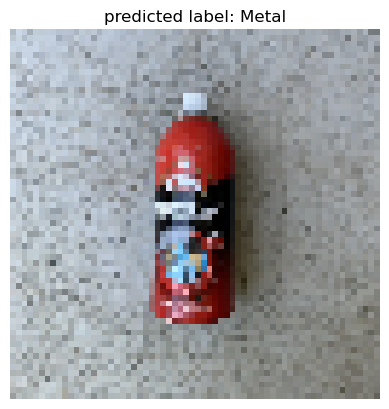

Predict end: 2024-12-07 00:22:25.505930
Prediction time: 0:00:00.128592


In [45]:
# Prediction time for model 3
start_time = datetime.now()
print('Predict start:', start_time)

IMAGE_SIZE = (64, 64)
test_image1 = cv2.imread("C:/test_ds/Metal/Metal_30.jpg")
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)
test_image1 = cv2.resize(test_image1, IMAGE_SIZE) 
im1= tf.constant(test_image1, dtype = tf.float32)
im1= tf.expand_dims(im1,axis = 0)
plt.title('predicted label: ' + class_names[np.argmax(model_3(im1))])
plt.imshow(test_image1)
plt.grid(False)
plt.axis('off')
plt.show()

end_time = datetime.now()
print('Predict end:', end_time)
print('Prediction time:', end_time - start_time)